In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/mai/data",
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 3600 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot']

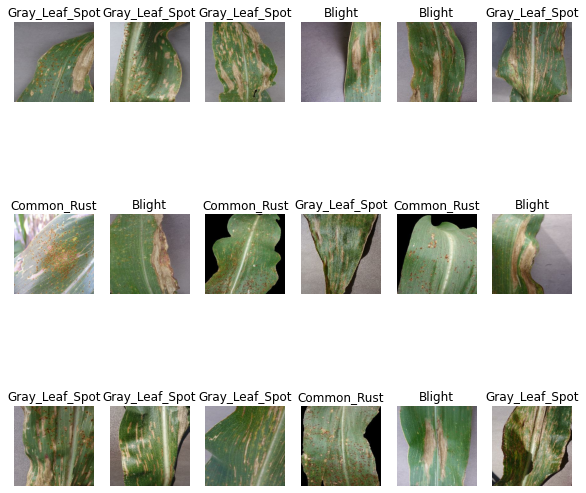

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
print(len(dataset)*train_size)
train_ds = dataset.take(54)
print(len(train_ds))
test_ds = dataset.skip(54)
print(len(test_ds))
val_size=0.1
print(len(dataset)*val_size)
val_ds = test_ds.take(6)
print(len(val_ds))
test_ds = test_ds.skip(6)

90.4
54
59
11.3
6


In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [13]:
modelf = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

modelf.build(input_shape=(32,256,256,3))

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
modelf.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
EPOCHS=50

In [16]:
history = modelf.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
90/90 [==============================] - 375s 344ms/step - loss: 0.7315 - accuracy: 0.5946 - val_loss: 0.6620 - val_accuracy: 0.6023
Epoch 2/50
90/90 [==============================] - 23s 260ms/step - loss: 0.6014 - accuracy: 0.6390 - val_loss: 0.6529 - val_accuracy: 0.6080
Epoch 3/50
90/90 [==============================] - 23s 257ms/step - loss: 0.5907 - accuracy: 0.6501 - val_loss: 0.6478 - val_accuracy: 0.5994
Epoch 4/50
90/90 [==============================] - 23s 258ms/step - loss: 0.5841 - accuracy: 0.6341 - val_loss: 0.6595 - val_accuracy: 0.6307
Epoch 5/50
90/90 [==============================] - 23s 256ms/step - loss: 0.5881 - accuracy: 0.6568 - val_loss: 0.6429 - val_accuracy: 0.6307
Epoch 6/50
90/90 [==============================] - 23s 256ms/step - loss: 0.5772 - accuracy: 0.6435 - val_loss: 0.6448 - val_accuracy: 0.6307
Epoch 7/50
90/90 [==============================] - 23s 256ms/step - loss: 0.5771 - accuracy: 0.6404 - val_loss: 0.6369 - val_accuracy: 0.653

In [17]:
modelf.save('fin.h5')

In [18]:
scores = modelf.evaluate(test_ds)

12/12 [==============================] - 7s 31ms/step - loss: 0.2251 - accuracy: 0.9245


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

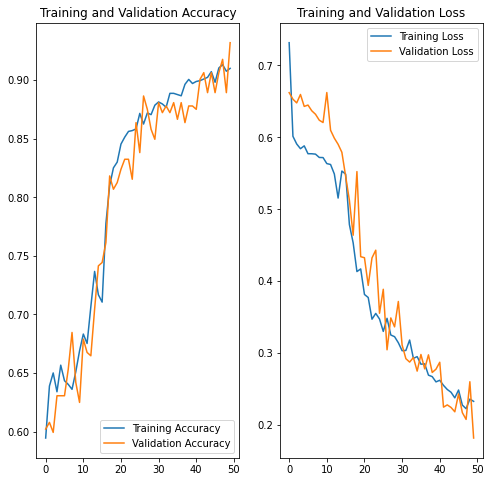

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

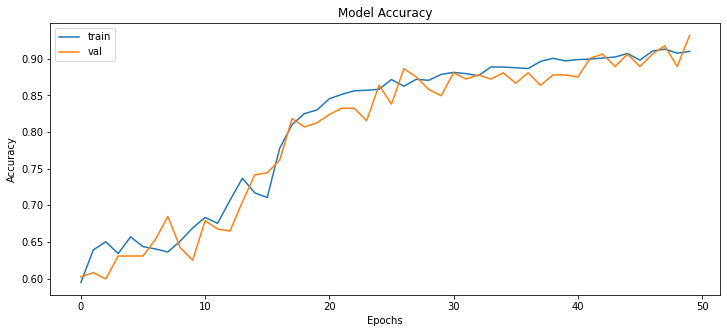

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

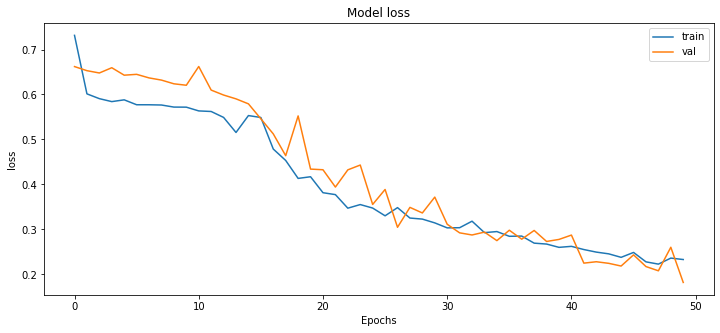

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

first image to predict
actual label: Gray_Leaf_Spot
predicted label: Gray_Leaf_Spot


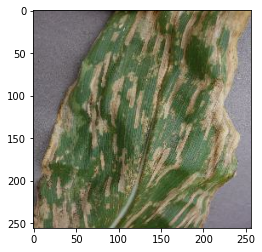

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = modelf.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(modelf, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelf.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

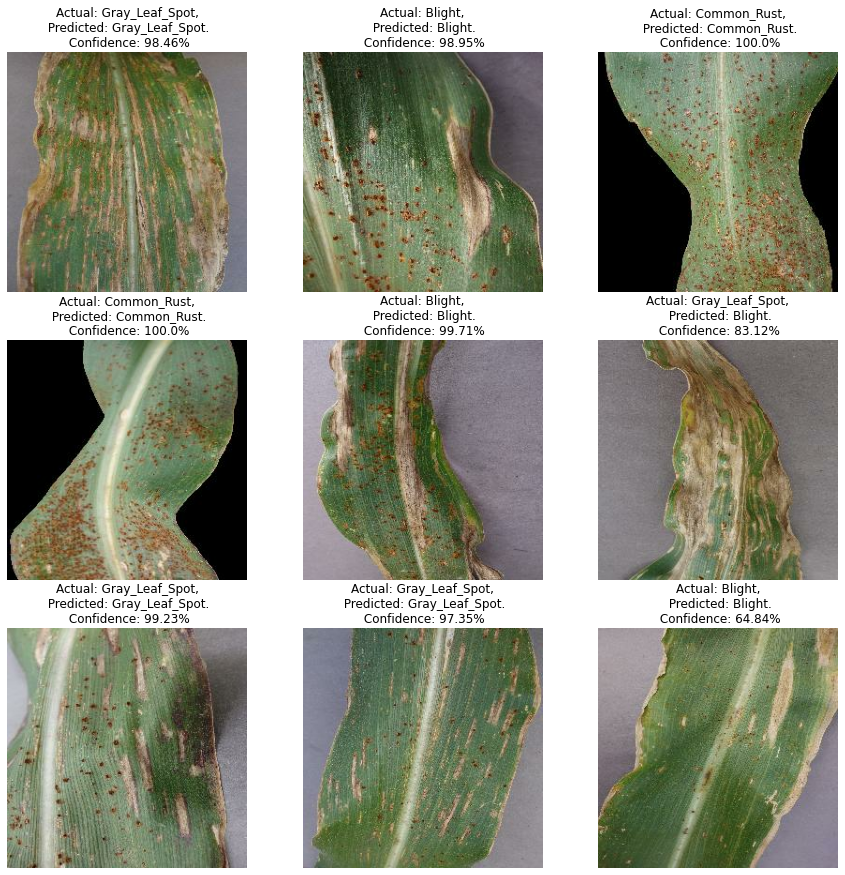

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(modelf, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
y_pred = []  
y_true = []  

for image_batch, label_batch in test_ds:  
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = modelf.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [67]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cm_df=pd.DataFrame(confusion_matrix(correct_labels,predicted_labels))
cm_df

Confusion Matrix


,0,1,2
0,124,3,3
1,1,124,1
2,17,4,107


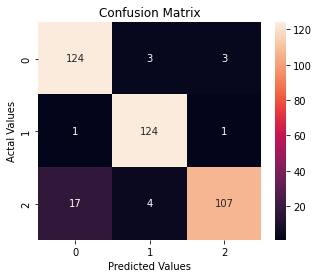

In [61]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [69]:
print('Classification Report\n')
print(classification_report(correct_labels,predicted_labels, target_names=class_names))

Classification Report

                precision    recall  f1-score   support

        Blight       0.87      0.95      0.91       130
   Common_Rust       0.95      0.98      0.96       126
Gray_Leaf_Spot       0.96      0.84      0.90       128

      accuracy                           0.92       384
     macro avg       0.93      0.92      0.92       384
  weighted avg       0.93      0.92      0.92       384

